In [83]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install tld -q

import re # regex
from urllib.parse import urlparse
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (10, 6)

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, f1_score, recall_score, accuracy_score, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance

from pprint import pprint
from tld import get_tld, is_tld

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malicious-urls-dataset/malicious_phish.csv


In [2]:
raw = pd.read_csv("/kaggle/input/malicious-urls-dataset/malicious_phish.csv")
raw.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


# EDA 📚

In [3]:
# No null values; 651191 entries
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [4]:
# raw['type'] = raw['type'].astype('category') 
raw['url_type'] = raw['type'].map({'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}).astype(np.int64)
raw.sample(5)

,url,type,url_type
28229,http://mediaset.it/mediasetextra/articoli/temp...,benign,0
262220,dsbp.cx/index.php?page=cat.html,benign,0
546189,http://42.113.104.40:10796/.i,malware,2
448138,paperbackswap.com/John-Jennings/author/,benign,0
495734,trumann.flowerhand.com/,benign,0


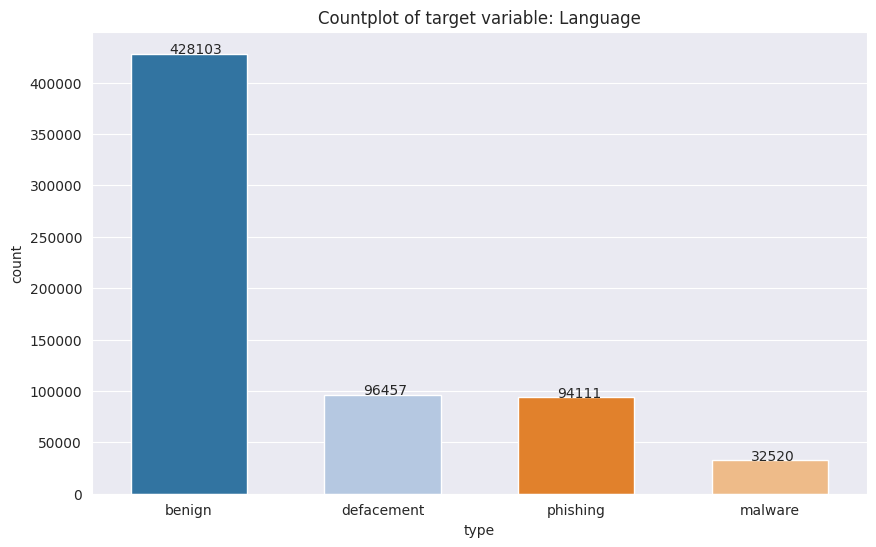

In [5]:
# Countplot
ax = sns.countplot(data=raw, x=raw.type, palette='tab20', width=.6, order=raw.type.value_counts().index)

for p, label in zip(ax.patches, raw.type.value_counts()):
    ax.annotate(label, (p.get_x() + .20, p.get_height() + 1))
ax.set_title('Countplot of target variable: Language')
plt.show()

In [6]:
def process_tld(url):
    try:
        res = get_tld(url, as_object=True, fail_silently=False, fix_protocol=True)
        domain = res.parsed_url.netloc
    except :
        domain = None
    return domain

In [7]:
# *** omit the (www.) from the URL which is in fact a sub domain in itself. ***
raw['url'] = raw['url'].replace('www', '', regex=True)
raw['url_length'] = raw['url'].apply(len)
raw['domain'] = raw['url'].apply(lambda x: process_tld(x))
raw.sample(10)

,url,type,url_type,url_length,domain
260595,iradiobiztv.blogspot.com/2011/06/canal-d-izle....,benign,0,50,iradiobiztv.blogspot.com
231855,youtube.com/watch?v=fXmZFRSYHOE,benign,0,31,youtube.com
218747,askbiography.com/bio/Raymond_Rougeau.html,benign,0,41,askbiography.com
401503,http://.rockabilly.it/gruppi/5-4sotto.html,defacement,1,42,.rockabilly.it
133184,schoolfinder.com/schools/programDetail.asp?Pro...,benign,0,70,schoolfinder.com
496206,biz.yahoo.com/e/111103/gxp10-q.html,benign,0,35,biz.yahoo.com
453778,upcoming.yahoo.com/event/8548275/MO/Kansas-Cit...,benign,0,91,upcoming.yahoo.com
192984,rivals.yahoo.com/ncaa/basketball/teams/map/stats,benign,0,48,rivals.yahoo.com
68408,x1075lasvegas.radio.com/category/music/,benign,0,39,x1075lasvegas.radio.com
496264,manhattan.ny.house.info/,benign,0,24,manhattan.ny.house.info


In [8]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    raw[a] = raw['url'].apply(lambda i: i.count(a))
raw.head()

,url,type,url_type,url_length,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [9]:
def abnormal_url(url: str) -> int:
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [10]:
raw['abnormal_url'] = raw['url'].apply(lambda x: abnormal_url(x))

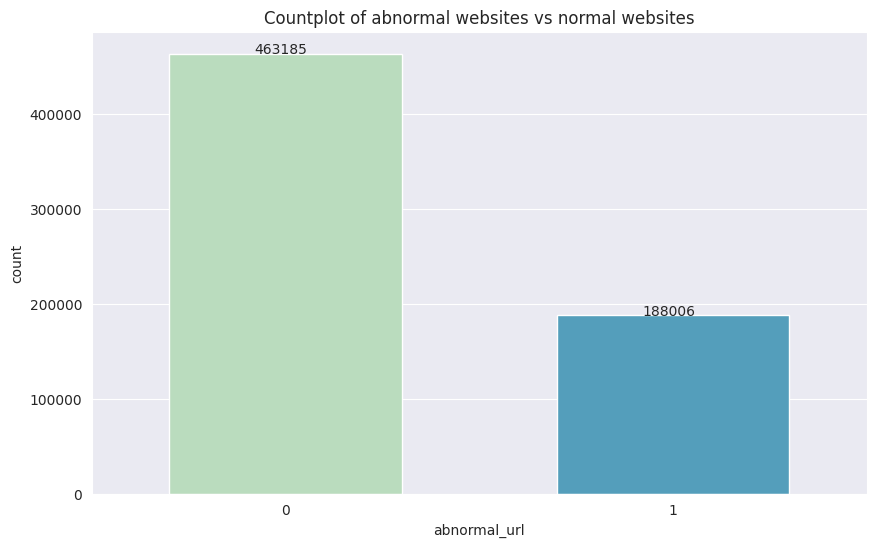

In [11]:
ax = sns.countplot(
    data=raw, x=raw.abnormal_url, palette='GnBu',width=.6, order=raw.abnormal_url.value_counts().index)

for p, label in zip(ax.patches, raw.abnormal_url.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of abnormal websites vs normal websites')
plt.show()

In [12]:
def httpSecured(url: str) -> int:
    htp = urlparse(url).scheme
    match = str(htp)
    if match == 'https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [13]:
raw['https'] = raw['url'].apply(lambda x: httpSecured(x))

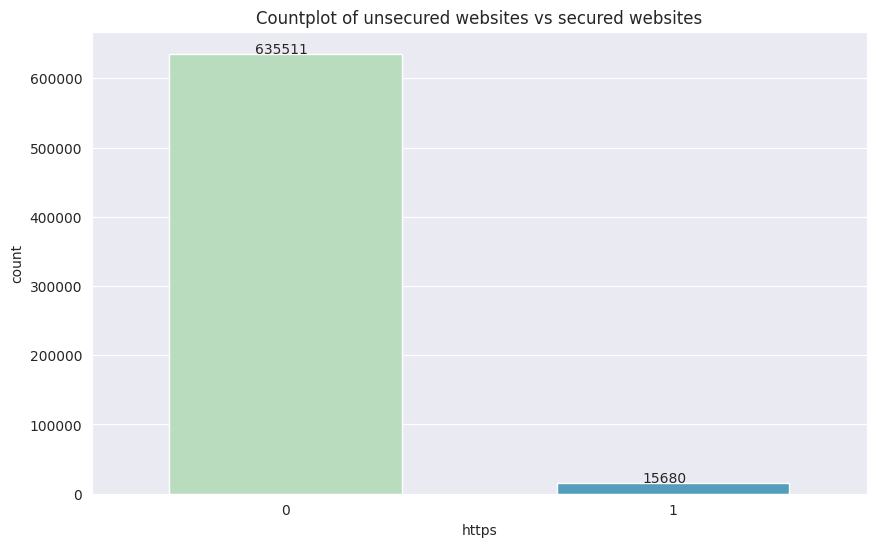

In [14]:
ax = sns.countplot(data=raw, x=raw.https, palette='GnBu',width=.6, order=raw.https.value_counts().index)

for p, label in zip(ax.patches, raw.https.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of unsecured websites vs secured websites')
plt.show()

In [15]:
def digit_count(url: str) -> int:
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

# Counts the number of letter characters in a URL
def letter_count(url: str) -> int:
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [16]:
raw['digits']  = raw['url'].apply(lambda x: digit_count(x))
raw['letters'] = raw['url'].apply(lambda x: letter_count(x))

In [17]:
raw.sample(10)

,url,type,url_type,url_length,domain,@,?,-,=,.,...,+,$,!,*,",",//,abnormal_url,https,digits,letters
429069,http://teedinrayong.com/index.php?option=com_a...,defacement,1,121,teedinrayong.com,0,1,0,7,2,...,0,0,0,0,0,1,1,0,4,94
228743,blogto.com/filmmakers/ed_gass-donnelly/,benign,0,39,blogto.com,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,33
604328,soundad.com/sounds.html,phishing,3,23,soundad.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,20
59774,robertmorinbuilder.com/,benign,0,23,robertmorinbuilder.com,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,21
87102,videosurf.com/elias-toufexis-25917,benign,0,34,videosurf.com,0,0,2,0,1,...,0,0,0,0,0,0,0,0,5,25
564350,pastehtml.com/view/bcsngkpcv.html,benign,0,33,pastehtml.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,29
523805,http://lpdfg.timoknow.beget.tech/pdf_tax/,phishing,3,41,lpdfg.timoknow.beget.tech,0,0,0,0,3,...,0,0,0,0,0,1,1,0,0,32
266813,dillyletterjackets.com/,benign,0,23,dillyletterjackets.com,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,21
68558,catholicchurchjersey.com/,benign,0,25,catholicchurchjersey.com,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,23
355542,visitosceolacounty.com/,benign,0,23,visitosceolacounty.com,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,21


In [18]:
# ** Checks to see whether URL contains a shortening service **
def shortening_service(url: str) -> int:
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [19]:
raw['shortening_service'] = raw['url'].apply(lambda x: shortening_service(x))

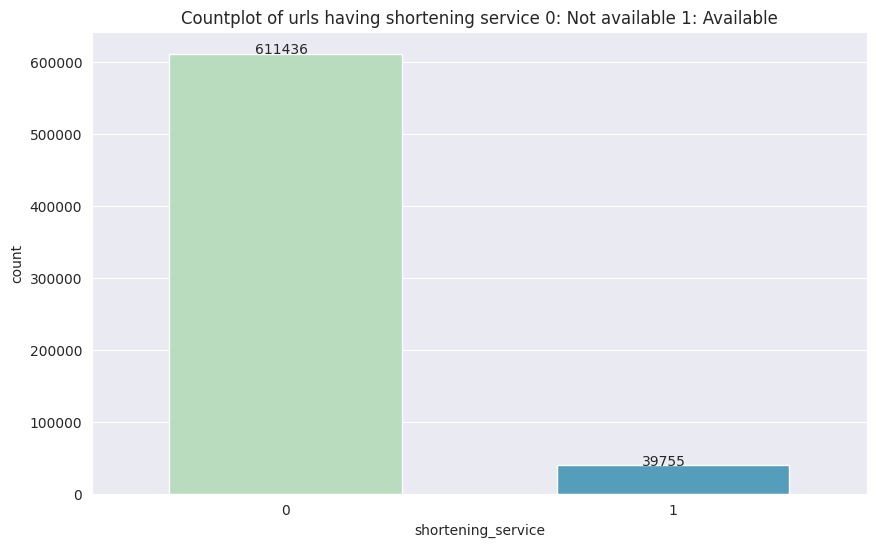

In [20]:
ax = sns.countplot(
    data=raw, 
    x=raw.shortening_service, 
    palette='GnBu',
    width=.6,
    order=raw.shortening_service.value_counts().index)

for p, label in zip(ax.patches, raw.shortening_service.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of urls having shortening service 0: Not available 1: Available')
plt.show()

In [21]:
def having_ip_address(url: str) -> int:
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [22]:
raw['has_ip_address'] = raw['url'].apply(lambda x: having_ip_address(x))
raw.has_ip_address.value_counts()

has_ip_address
0    638703
1     12488
Name: count, dtype: int64

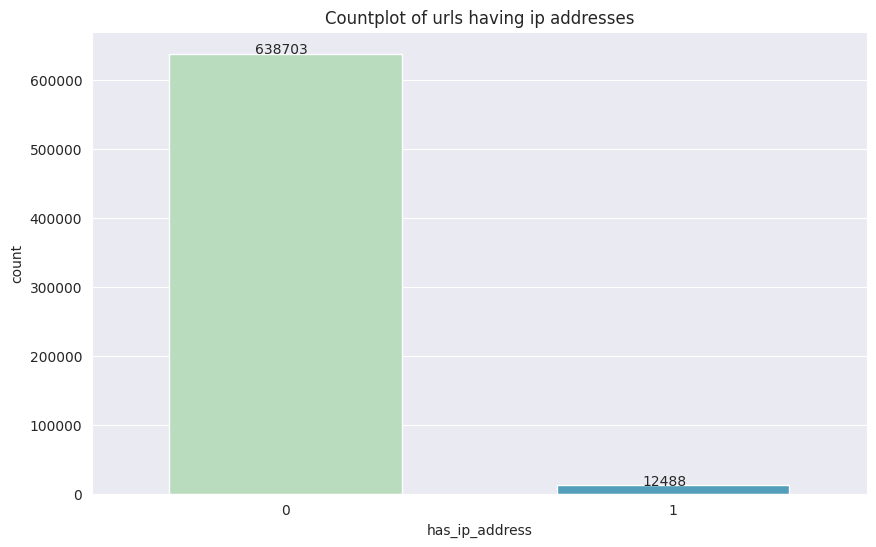

In [23]:
ax = sns.countplot(
    data=raw, 
    x=raw.has_ip_address, 
    palette='GnBu',
    width=.6,
    order=raw.has_ip_address.value_counts().index)

for p, label in zip(ax.patches, raw.has_ip_address.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of urls having ip addresses')
plt.show()

In [ ]:
# - how long exactly these phishing or malicious links are as a string, [to see any pattern]
# raw[raw['type'] == 'phishing'][['url', 'url_length']].describe().T
# raw[raw['type'] == 'malware'][['url', 'url_length']].describe().T
# raw[raw['type'] == 'benign'][['url', 'url_length']].describe().T

# Correlation Plot: HeatMap 📍 

In [24]:
raw.head()

,url,type,url_type,url_length,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,shortening_service,has_ip_address
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0


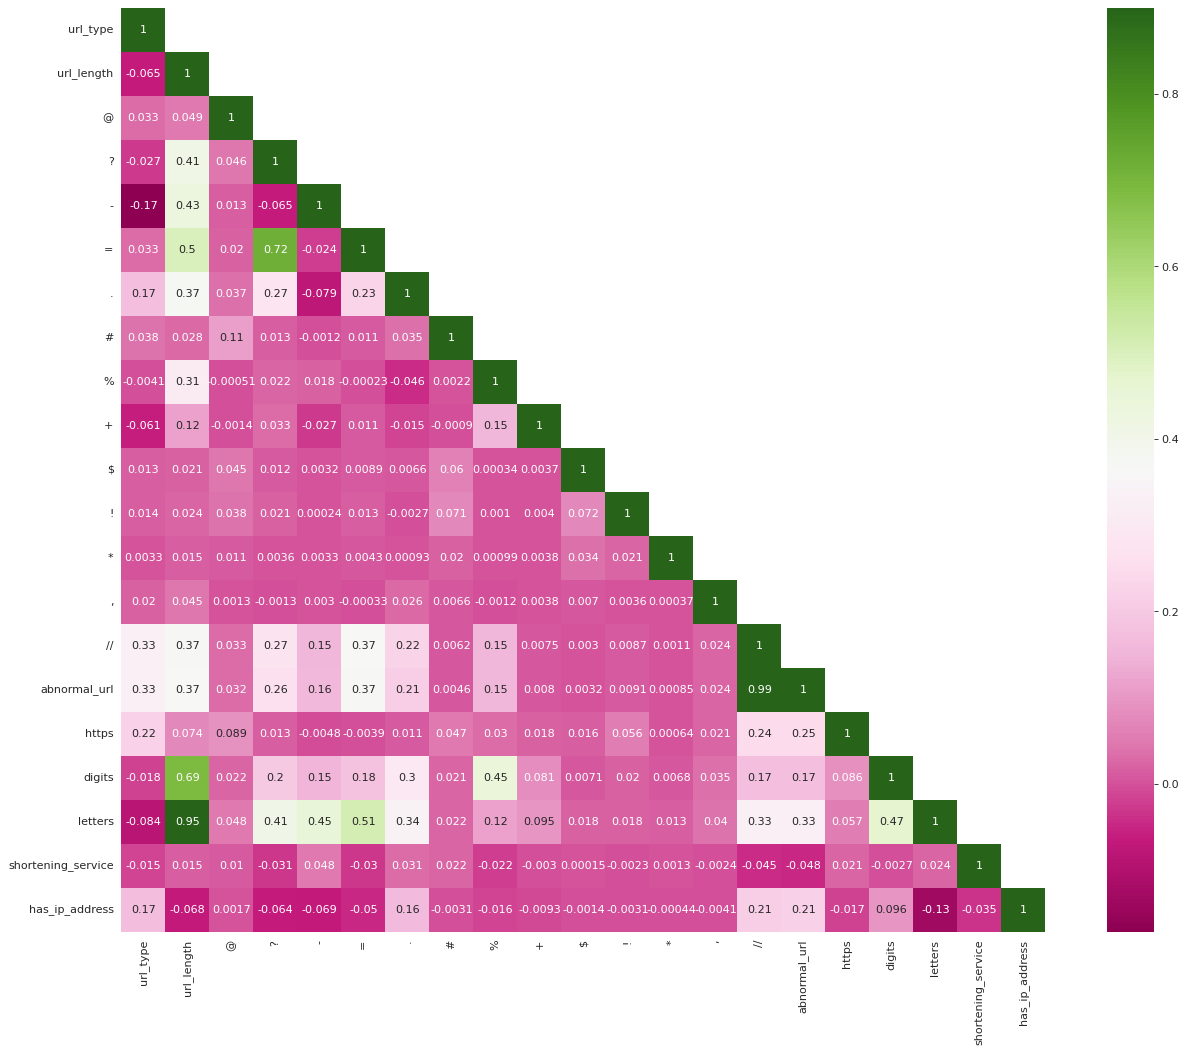

In [25]:
numeric_cols = [
    col for col in raw.columns if raw[col].dtype in ['int', 'float']
]

corr = raw[numeric_cols].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False;

sns.set_style('whitegrid') # I like heatmap on a white background
plt.figure(figsize = (20, 15), dpi = 80)
sns.heatmap(corr, mask = mask, square = True, annot = True, vmax = .9, cmap = 'PiYG')
plt.grid(False)
plt.show()

In [46]:
# - features to remove
# url, type, domain
# - features to keep for model training
# numeric_cols, url_type <- target variable

target = raw[numeric_cols].pop('url_type')
inputs = raw[numeric_cols].drop(columns='url_type', axis=1)

In [47]:
scaler = StandardScaler().fit(raw[inputs.columns.to_list()])
raw[inputs.columns.to_list()] = scaler.transform(raw[inputs.columns.to_list()])
raw[inputs.columns.to_list()]

,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,shortening_service,has_ip_address
0,-0.977485,-0.040954,-0.507190,-0.185091,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.472396,-1.007653,-0.254988,-0.139829
1,-0.551230,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.386931,-0.498432,-0.254988,-0.139829
2,-0.640968,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.386931,-0.625737,-0.254988,-0.139829
3,0.570493,-0.040954,1.759256,-0.185091,2.238780,0.539700,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,1.529649,1.569609,-0.157077,0.125854,0.488186,-0.254988,-0.139829
4,3.935662,-0.040954,1.759256,-0.185091,1.579567,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,1.529649,1.569609,-0.157077,1.407817,4.912049,-0.254988,-0.139829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,-0.461492,-0.040954,-0.507190,-0.521362,-0.398075,0.539700,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,0.553175,-0.753042,-0.254988,-0.139829
651187,-0.349320,-0.040954,-0.507190,0.151181,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,0.125854,-0.498432,3.921747,-0.139829
651188,-0.461492,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.216003,-0.466605,3.921747,-0.139829
651189,-0.326886,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.472396,-0.275647,-0.254988,-0.139829


In [50]:
raw_sampled = raw[numeric_cols].sample(n=70_000)
raw_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 594617 to 290903
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url_type            70000 non-null  int64  
 1   url_length          70000 non-null  float64
 2   @                   70000 non-null  float64
 3   ?                   70000 non-null  float64
 4   -                   70000 non-null  float64
 5   =                   70000 non-null  float64
 6   .                   70000 non-null  float64
 7   #                   70000 non-null  float64
 8   %                   70000 non-null  float64
 9   +                   70000 non-null  float64
 10  $                   70000 non-null  float64
 11  !                   70000 non-null  float64
 12  *                   70000 non-null  float64
 13  ,                   70000 non-null  float64
 14  //                  70000 non-null  float64
 15  abnormal_url        70000 non-null  float64
 16  htt

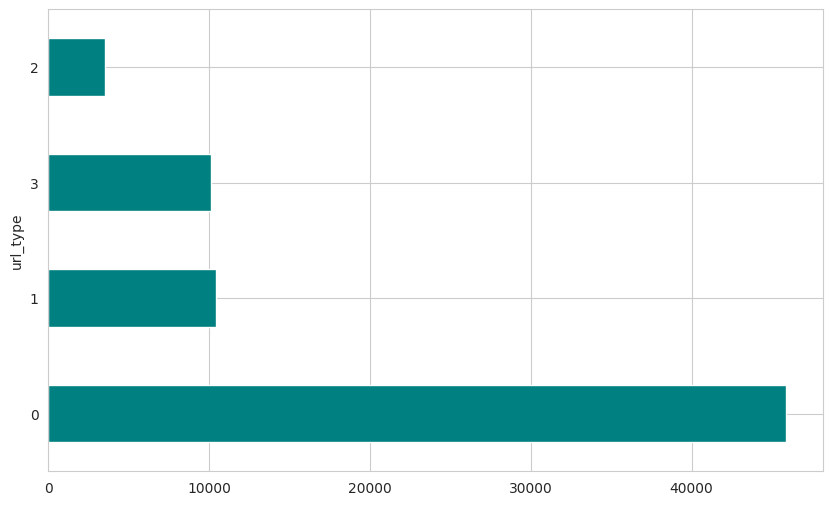

In [56]:
raw_sampled.url_type.value_counts().plot.barh(color='teal');

In [64]:
train_inputs, test_inputs, train_target, test_target = split(
    raw_sampled[inputs.columns], raw_sampled.url_type, test_size=.40, stratify=raw_sampled.url_type, random_state=42)
print(
    f"Train shape: {train_inputs.shape} | Target shape: {train_target.shape}", 
    f"Test shape: {test_inputs.shape} | Test target shape: {test_target.shape}", 
    sep="\n",
)

Train shape: (42000, 20) | Target shape: (42000,)
Test shape: (28000, 20) | Test target shape: (28000,)


# Features Selection 👾

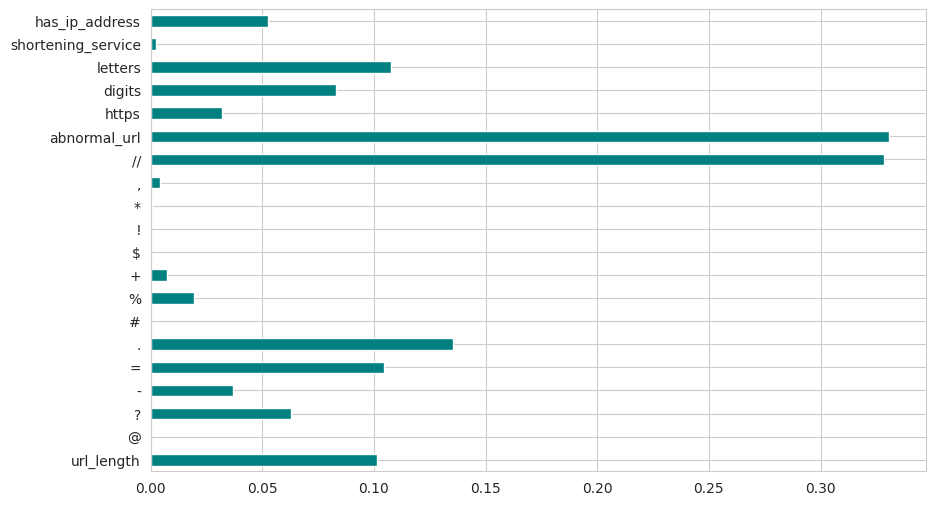

In [65]:
importances = mutual_info_classif(train_inputs, train_target)
feat_importances = pd.Series(importances, train_inputs.columns)
feat_importances.plot(kind='barh', color='teal');

In [ ]:
# has_ip_add, letters, digits, abnormal_rul, //, ., =, ?, url_length

# Experiments

In [78]:
def train(model, X, y, average: str = 'macro') -> None:
    preds = model.predict(X)
    metric_summary(y, preds, average)
    
def metric_summary(y, preds, average) -> None:
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average=average)
    rcl = recall_score(y, preds, average=average)
    print(
        f"Accuracy: {(acc * 100):.2f} %", 
        f"f1: {f1:.2f}", 
        f"recall: {rcl:.2f}", sep="\n"
    )

In [66]:
rffst = RandomForestClassifier(random_state=42).fit(train_inputs, train_target)
train(model=rffst, X=test_inputs, y=test_target)

Accuracy: 90.74 %
f1: 0.87
recall: 0.85


In [70]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf  = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

random_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features, 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split, 
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'criterion': criterion,
}

rf_ = RandomForestClassifier()

rf_cv = RandomizedSearchCV(
    estimator=rf_, 
    param_distributions=random_grid, 
    n_iter=5, 
    cv=3, 
    verbose=2, 
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(train_inputs, train_target)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=2,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [85]:
pprint(rf_cv.best_params_)

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}


In [107]:
def test_params(model, average: str='macro', **params) -> None:
    model = model(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_target)
    train(model, test_inputs, test_target, average)
    return

In [108]:
test_params(
    model=RandomForestClassifier,
    n_estimators=200, 
    min_samples_split=10, 
    min_samples_leaf=2, 
    max_features='log2',
    max_depth=50, 
    criterion='gini', 
    bootstrap=True,
)

Accuracy: 90.09 %
f1: 0.85
recall: 0.83


In [109]:
test_params(
    model=XGBClassifier,
    n_estimators=200, 
    min_samples_split=10, 
    min_samples_leaf=2, 
    max_features='log2',
    max_depth=50, 
    criterion='gini', 
    bootstrap=True,
    average='weighted',
)

[20:37:26] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "criterion", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

Accuracy: 90.62 %
f1: 0.90
recall: 0.91


In [110]:
test_params(
    model=XGBClassifier,
    n_estimators=200, 
    max_depth=50, 
)

Accuracy: 90.62 %
f1: 0.87
recall: 0.86


***** lg *****
Test Accuracy :  81.99%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     18359
           1       0.77      0.93      0.84      4183
           2       0.85      0.62      0.71      1410
           3       0.45      0.09      0.15      4048

    accuracy                           0.82     28000
   macro avg       0.73      0.65      0.65     28000
weighted avg       0.78      0.82      0.78     28000

             Confusion_matrix 


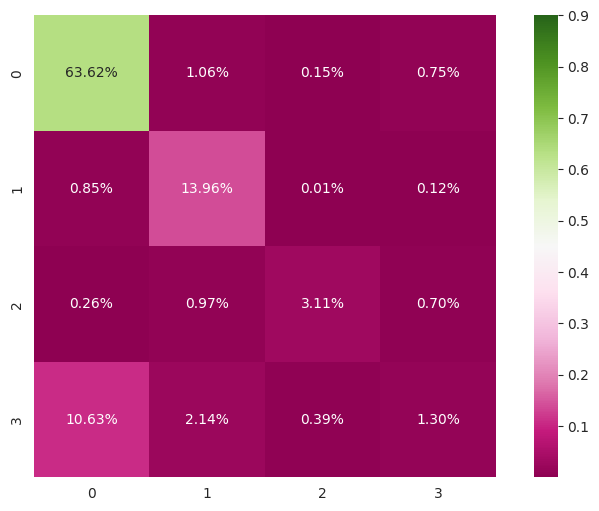

********************** END **********************
***** lgcv *****
Test Accuracy :  82.44%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.85      0.97      0.90     18359
           1       0.78      0.94      0.85      4183
           2       0.85      0.65      0.74      1410
           3       0.49      0.09      0.16      4048

    accuracy                           0.82     28000
   macro avg       0.74      0.66      0.66     28000
weighted avg       0.78      0.82      0.78     28000

             Confusion_matrix 


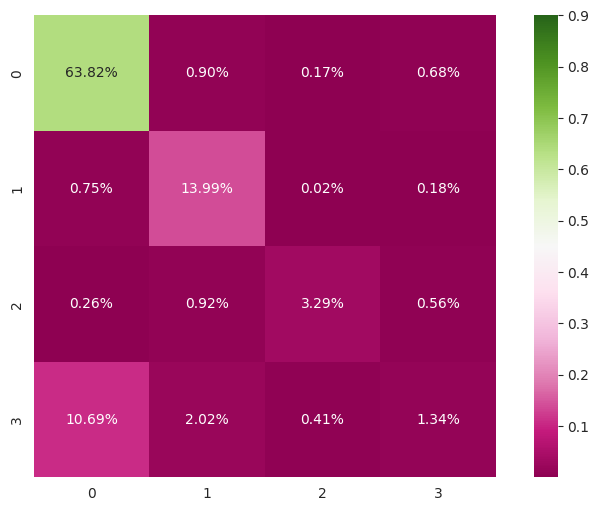

********************** END **********************
***** tree *****
Test Accuracy :  89.42%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     18359
           1       0.90      0.91      0.91      4183
           2       0.86      0.87      0.86      1410
           3       0.71      0.63      0.66      4048

    accuracy                           0.89     28000
   macro avg       0.85      0.84      0.84     28000
weighted avg       0.89      0.89      0.89     28000

             Confusion_matrix 


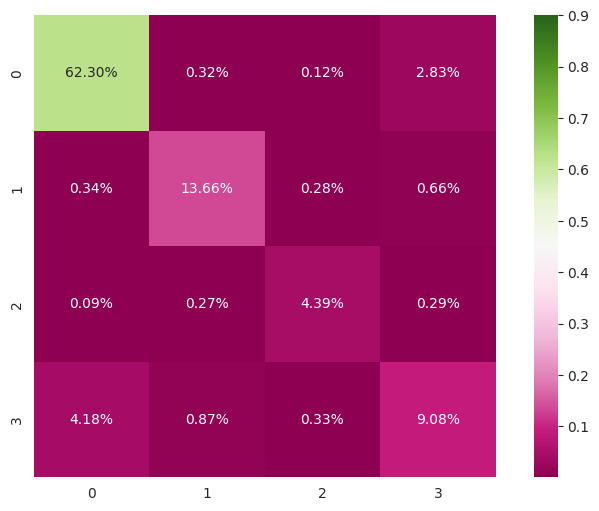

********************** END **********************
***** forest *****
Test Accuracy :  90.74%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     18359
           1       0.91      0.94      0.93      4183
           2       0.92      0.87      0.89      1410
           3       0.75      0.64      0.69      4048

    accuracy                           0.91     28000
   macro avg       0.88      0.85      0.87     28000
weighted avg       0.90      0.91      0.90     28000

             Confusion_matrix 


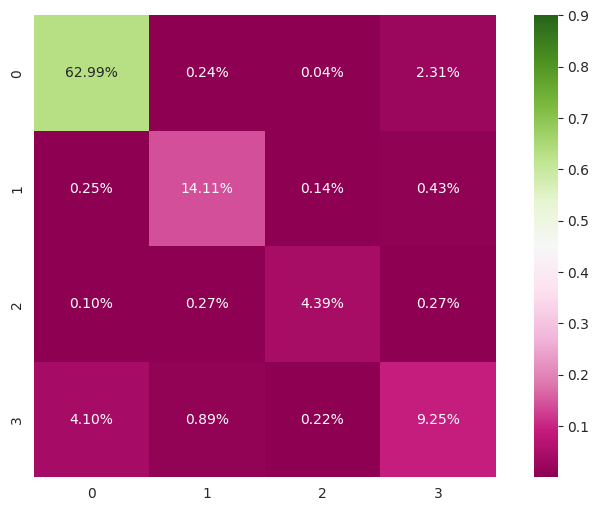

********************** END **********************
***** extas *****
Test Accuracy :  90.64%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     18359
           1       0.91      0.94      0.92      4183
           2       0.92      0.88      0.90      1410
           3       0.76      0.63      0.69      4048

    accuracy                           0.91     28000
   macro avg       0.88      0.85      0.86     28000
weighted avg       0.90      0.91      0.90     28000

             Confusion_matrix 


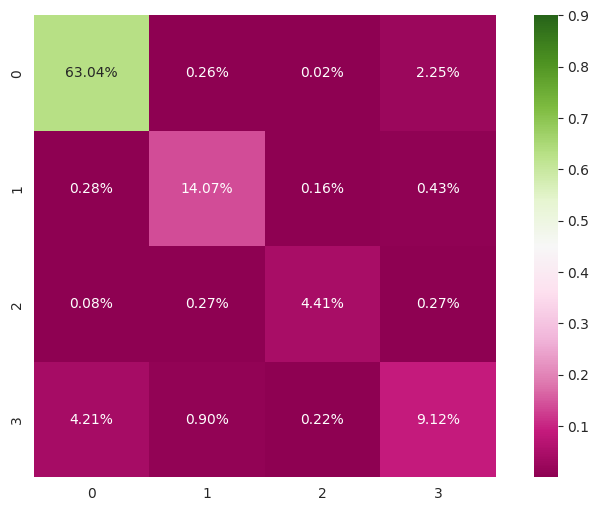

********************** END **********************
***** xgb *****
Test Accuracy :  90.00%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     18359
           1       0.89      0.96      0.92      4183
           2       0.93      0.84      0.88      1410
           3       0.76      0.57      0.65      4048

    accuracy                           0.90     28000
   macro avg       0.88      0.83      0.85     28000
weighted avg       0.89      0.90      0.89     28000

             Confusion_matrix 


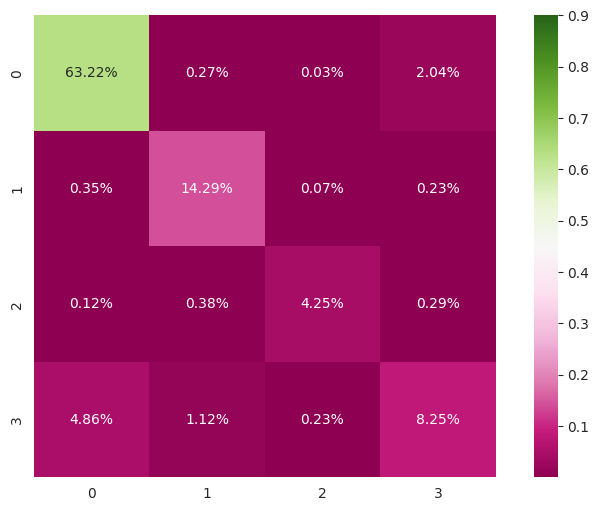

********************** END **********************


In [131]:
test_accuracies = list()

for name, model in estimators:
    print(f"***** {name} *****")
    model.fit(train_inputs, train_target)
    preds = model.predict(test_inputs)
    accuracy = accuracy_score(test_target, preds)
    test_accuracies.append(accuracy)
    
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(accuracy*100))
    print('\033[01m              Classification Report \033[0m')
    print(classification_report(test_target, preds,))
    
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(test_target, preds,)
    plot_ = sns.heatmap(
        cf_matrix/np.sum(cf_matrix), annot=True, square=True, vmax=.9, fmt='0.2%', cmap='PiYG',)
    plt.show()
    
    print("********************** END **********************")

In [ ]:
# Contnuing